In [140]:
# Import Package
from collections import Counter
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

import math

In [3]:
# Decision Tree Implemention

def entropy(y):
    hist = np.bincount(y)
    ps = hist / len(y)
    return -np.sum([p * np.log2(p) for p in ps if p > 0])


class Node:
    def __init__(
        self, feature=None, threshold=None, left=None, right=None, *, value=None
    ):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None


class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None

    # get training data and traning label
    def fit(self, X, y):
        #grow tree
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1]) #ta tedad az kole feature mojoud bishtar nabashe
        self.root = self._grow_tree(X, y)

    def predict(self, X):
        #traverse tree
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape # تعداد نمونه های موجود (تعداد ردیف ها ) و تعداد ویژگی‌های موجود (تعداد ستونها)
        n_labels = len(np.unique(y))  #تعداد لیبل متمایز

        # stopping criteria # متوقف کردن رشد درخت با یکی از شرایط زیر
        if (
            depth >= self.max_depth #عمق فعلی از نهایت عمقی که میتونه باشه پیشی بگیره 
            or n_labels == 1 #همه ی فیچرهایی که موندن همشون دارای لیبل های یکسان هستند یا به عبارتی فقط یک لیبل  موجوده
            or n_samples < self.min_samples_split # تعداد نمونه های موجود یا همون ردیف هایی که مونده از کمترین مقداری که اینجا ۲ تنظیم شده کمتر باشه یعنی یک ردیف بیشتر نداریم
        ):
            leaf_value = self._most_common_label(y) # حالا که ته رشد درخته بیا، اون لیبلی که در اینجا بیشترین تکرار را داره به عنوان برگ برگردون
            return Node(value=leaf_value)

        # اگر درخت باید رشد کند و باید نود جدید ساخته بشه


        #هدف این بخش این هست که به صورت رندم بیاد جایگشتی از فیچرها را در نظر بگیره و ریپلیس اخر برای اینکه هر بار که اجرا میشه در آینده جایگشت تکراری نده
        # should:  (self.n_feats <=  n_features)
        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

        # greedily select the best split according to information gain
        # هدف اینجا این هست که بهترین فیچر و بهترین تریشهولد اون را برگردونه تا بفهمیم درختو چطوری ریز کنیم
        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)

        # grow the children that result from the split
        # حالا که بهترین فیچر برای جداسازی به همراه تریشهولد مناسبش را متوجه شدیم، باید بریم درخت و بر این اساس بشکنیم و بریم پایین
        
        # این خط عملا تقسیم همون چیزی هست که قبلا برای محاسبه‌ی آی.جی حسابش کردیم، و حالا که فهمیدیم این بهترینش بود خب دوباره حسابش میکنیم
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        # اون ردیفهایی که تقسیم شدند تمامی ستونهاشون را میخوایم و لیبلهای مورد نیاز را
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feat, best_thresh, left, right)

    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        
        # اون دنباله‌ی رندمی از فیچرها که مشخص کردیم را داریم، حالا هر بار به ترتیب سراغ یکی از فیچر های این دنباله میریم
        for feat_idx in feat_idxs:
            # پس از انتخاب فیچر باید بریم برای انتخاب تریشهولد از بین مقادیر موجود برای اون فیچر(مقادیر اون ستون)
            X_column = X[:, feat_idx]
            # کل مقادیر متمایز اون ستون را پیدا میکنیم و هر بار یکی را به عنوان تریشهولد در نظر میگیریم
            # اینکه چرا مقدار تریشهولد عددی غیر از مقادیر نباشه را نمیدونم مثلا یک عددی بین این مقادیر که موجود نیست
            thresholds = np.unique(X_column)
            # برای هر تریشهولد میره تست کنه تا ببینه کدوم تریشهولد بهترین نتیجه را میده
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold

        return split_idx, split_thresh

    def _information_gain(self, y, X_column, split_thresh):
        # parent loss
        parent_entropy = entropy(y)

        # generate split
        # برای محاسبه باید ببینیم کیا بزرگتر از تریشهولد و کیا کوچیکتر از تریشهولد هستند 
        # خروجی این بخش شماره ردیف اونایی که کوچیکتر از تریشهولد و اونایی که بزرگتر از تریشهولد هستند را برمیگردونه
        # شماره ردیف باعث میشه بتونیم با شماره ردیف به مقدار لیبلشون که در محاسبه اینتروپی نیاز داریم دسترسی بگیریم
        left_idxs, right_idxs = self._split(X_column, split_thresh)

        # اگر براساس رابطه‌ی آی.جی بری اگر یکی از بچه ها خالی باشه در واقع تریشهولد طوری باشه که همه را فرستاده باشه در یکی از بچه ها
        # عملا بر اساس محاسبه خواهیم داشت:
        # E(parent) - 1* E(child)
        # که درعمل بخش دوم دقیقا همان مقدار ای پرنت را خواهد داشت و حاصل برابر با صفر میشود
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # compute the weighted avg. of the loss for the children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        # با ایندکس ها به مقادیر لیبل های اون ایندکسهای مورد نظر دسترسی پیدا کردیم
        e_l, e_r = entropy(y[left_idxs]), entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        # information gain is difference in loss before vs. after split
        ig = parent_entropy - child_entropy
        return ig

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common


In [466]:
# Random Forest Implemetion

def bootstrap_sample(X, y):
    n_samples = X.shape[0]
    idxs = np.random.choice(n_samples, n_samples, replace=True)
    #result = pd.DataFrame(X.values[idxs], columns=['PassengerId', 'Pclass','Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'])
    result = pd.DataFrame(X.values[idxs], columns=['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'])
    return result, y[idxs]


def most_common_label(y):
    counter = Counter(y)
    most_common = counter.most_common(1)[0][0]
    return most_common


class RandomForest:
    def __init__(self, n_trees=10, min_samples_split=2, max_depth=100, n_feats=None):
        self.n_trees = n_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            clf = DecisionTreeClassifier(min_samples_split = self.min_samples_split,
                                         max_features = self.n_feats,
                                         max_depth = self.max_depth,
                                         class_weight = "balanced")
            
            X_samp, y_samp = bootstrap_sample(X, y)
            clf.fit(X_samp, y_samp)
            self.trees.append(clf)
        return self.trees

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(tree_preds, 0, 1)
        y_pred = [most_common_label(tree_pred) for tree_pred in tree_preds]
        return np.array(y_pred)

In [403]:
# Initialize Dataset and PreProcess Data
path ='train.csv'
path2 ='test.csv'
path3 ='gender_submission.csv'

dataset_x_y_train = pd.read_csv(path)
dataset_x_test = pd.read_csv(path2)
dataset_y_test = pd.read_csv(path3)

dataset_x_y_test = dataset_y_test.merge(dataset_x_test, on='PassengerId')
dataset = pd.concat([dataset_x_y_test, dataset_x_y_train])

dataset['Sex'] = dataset['Sex'].astype('category')
dataset['Cabin'] = dataset['Cabin'].astype('category')
dataset['Ticket'] = dataset['Ticket'].astype('category')
dataset['Embarked'] = dataset['Embarked'].astype('category')
dataset['Name'] = dataset['Name'].astype('category')

dataset['Sex'] = dataset['Sex'].cat.codes
dataset['Cabin'] = dataset['Cabin'].cat.codes
dataset['Ticket'] = dataset['Ticket'].cat.codes
dataset['Embarked'] = dataset['Embarked'].cat.codes
dataset['Name'] = dataset['Name'].cat.codes

dataset['Age'] = dataset['Age'].fillna(-1)
dataset['Fare'] = dataset['Fare'].fillna(-1)
#dataset.columns[dataset.isnull().any()].tolist()

dataset = dataset.sort_values(['PassengerId'])
dataset = dataset.reindex(columns=['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Survived'])

x = dataset.iloc[:891, :-1].values
y = dataset.iloc[:891, 11].values
x_train = pd.DataFrame(x, columns=['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'])
y_train = pd.DataFrame(y, columns=['Survived']).squeeze('columns')

x = dataset.iloc[891:, :-1].values
y = dataset.iloc[891:, 11].values
x_test = pd.DataFrame(x, columns=['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'])
y_test = pd.DataFrame(y, columns=['Survived']).squeeze('columns')

del x_train['Name']
del x_test['Name']

In [467]:
clf = RandomForest(n_trees=150, max_depth=4 ,n_feats=int(math.sqrt(x_test.columns.size)))
trees = clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

In [468]:
result = confusion_matrix(y_pred, y_test)
print("Confusion Matrix:")
print(result)
result1 = classification_report(y_test, y_pred)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_test,y_pred)
print("Accuracy:",result2)

Confusion Matrix:
[[229   6]
 [ 37 146]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.86      0.91       266
           1       0.80      0.96      0.87       152

    accuracy                           0.90       418
   macro avg       0.89      0.91      0.89       418
weighted avg       0.91      0.90      0.90       418

Accuracy: 0.8971291866028708


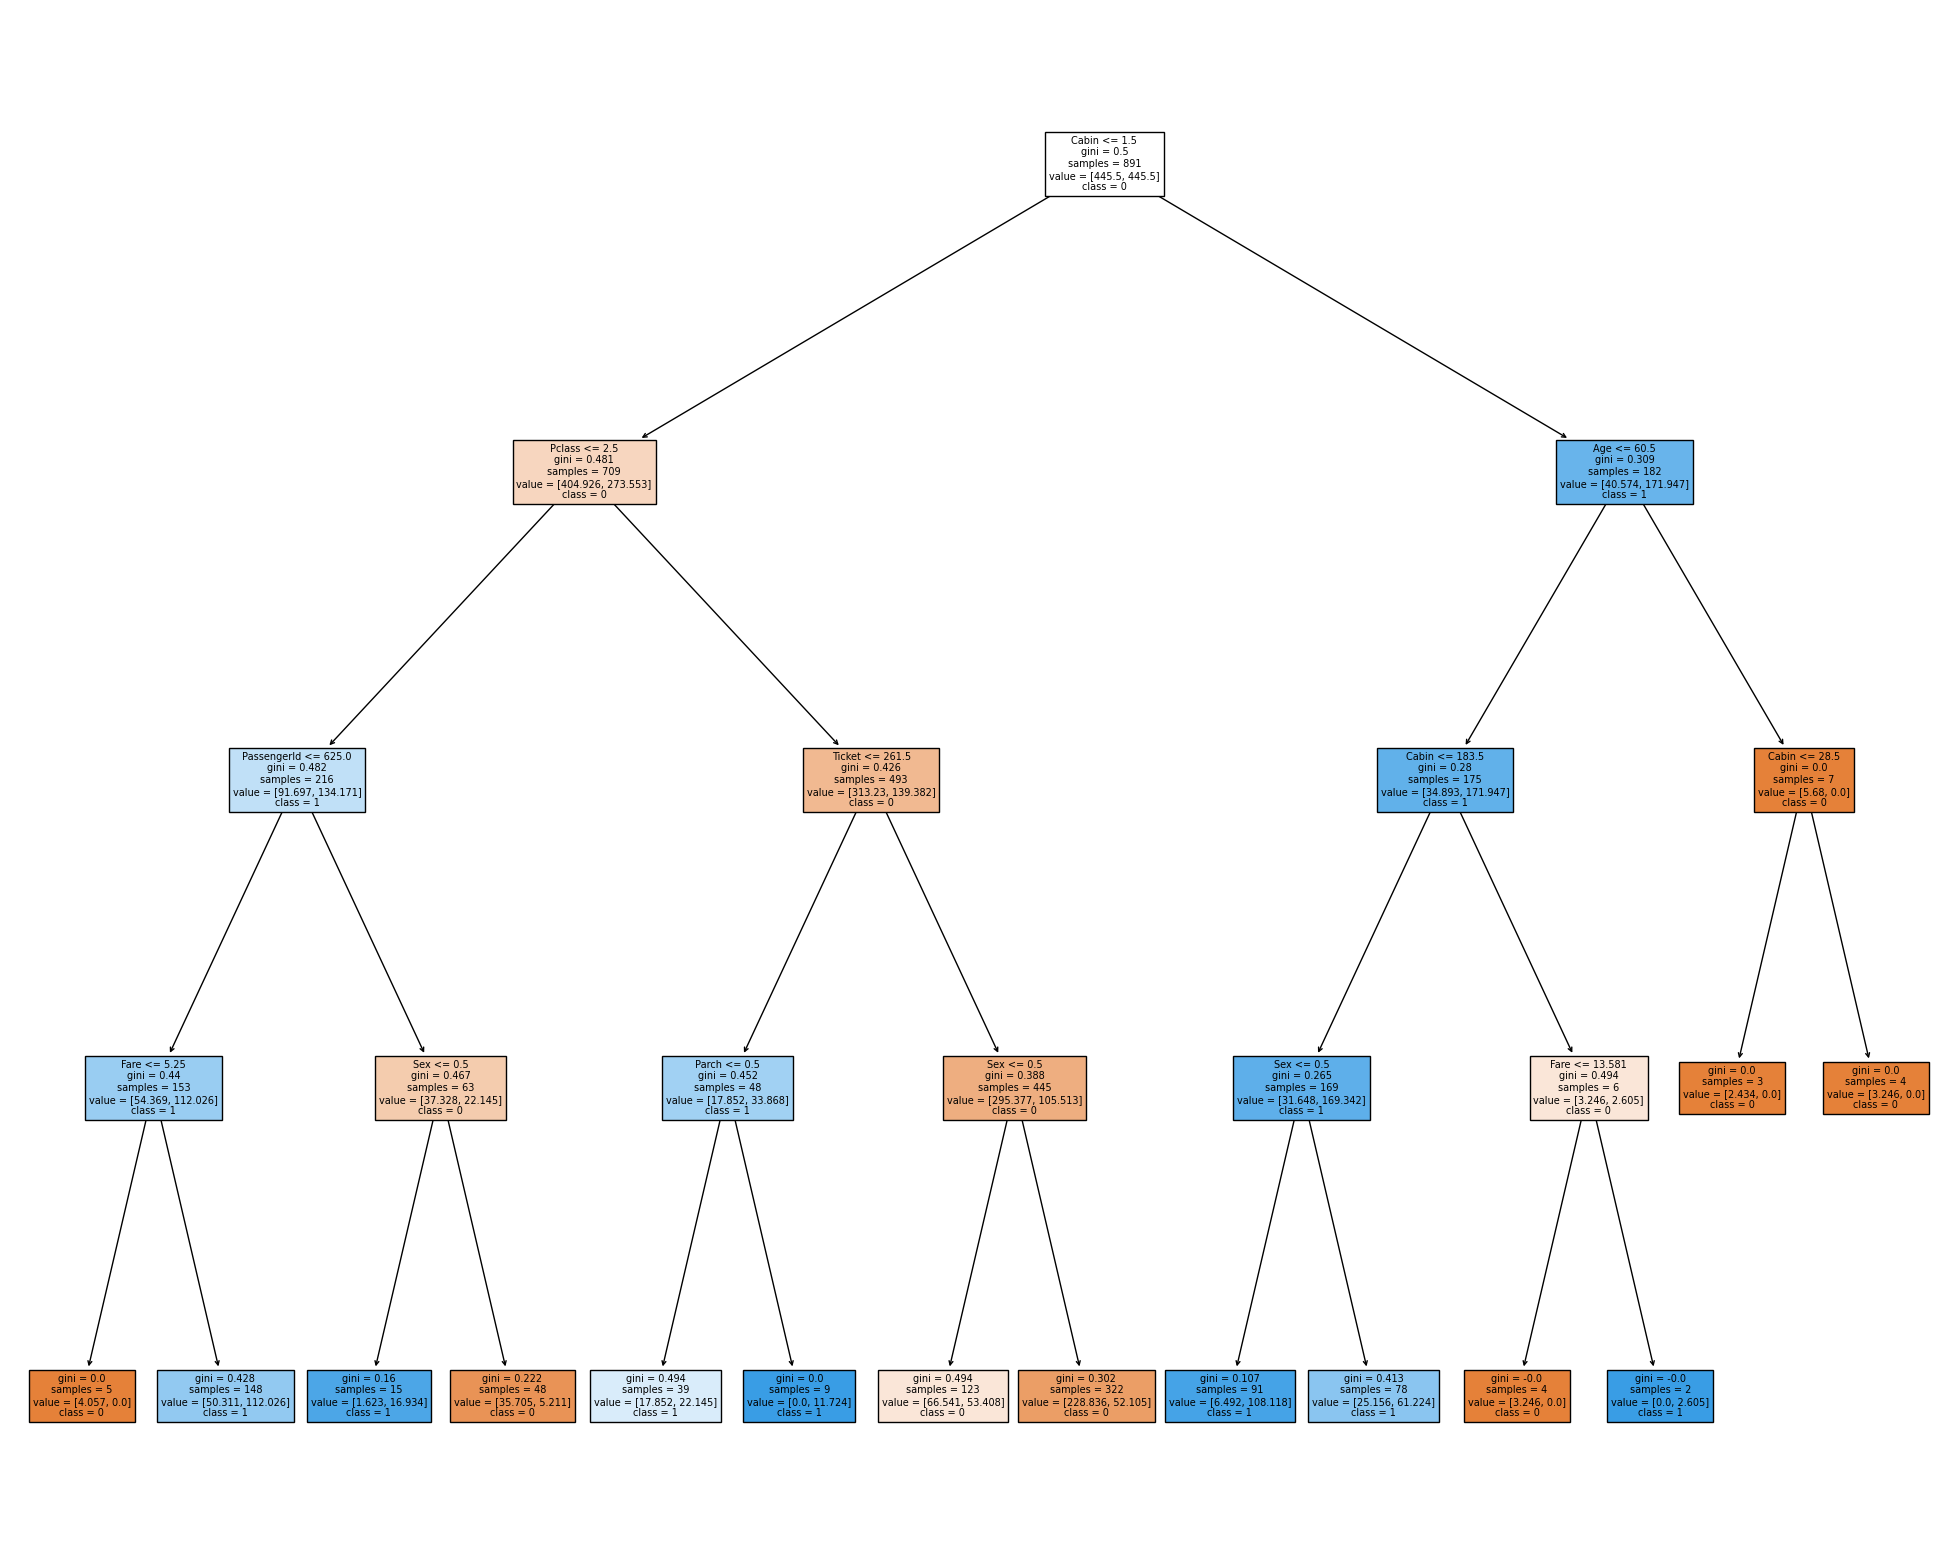

In [469]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(trees[0], 
                   feature_names=list(x_test.columns),  
                   class_names=["0", "1"],
                   filled=True)